In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# === Load original dataset ===
DATA = Path("/Users/thetsusann/Documents/ML/Energy404---Rooftop-Solar-Potential/New_approach/dataset/cleaned_datasets/top20_balanced_sample.parquet")
df = pd.read_parquet(DATA)

print("Original shape:", df.shape)
print("\nOriginal counts per type:\n", df["BuildingType"].value_counts())


Original shape: (958580, 12)

Original counts per type:
 BuildingType
single family residential    442224
multifamily residential      193430
commercial                   125447
public sector                 76208
industrial                    71843
peri-urban settlement         16960
schools                       14596
public health facilities       8009
hotels                         7493
small commercial               2370
Name: count, dtype: int64


In [2]:
# === Controlled downsampling (balance by BuildingType) ===
MAX_SAMPLES = 40000

balanced_df = (
    df.groupby("BuildingType", group_keys=False)
      .apply(lambda x: x.sample(n=min(len(x), MAX_SAMPLES), random_state=42))
      .reset_index(drop=True)
)

print("\nBalanced shape:", balanced_df.shape)
print("\nBalanced counts per type:\n", balanced_df["BuildingType"].value_counts())

# Optional: save it
OUT_PATH = Path("/Users/thetsusann/Documents/ML/Energy404---Rooftop-Solar-Potential/New_approach/dataset/cleaned_datasets/top20_balanced_by_type.parquet")
balanced_df.to_parquet(OUT_PATH, index=False)
print("\n✅ Saved to:", OUT_PATH)


Balanced shape: (249428, 12)

Balanced counts per type:
 BuildingType
commercial                   40000
industrial                   40000
multifamily residential      40000
public sector                40000
single family residential    40000
peri-urban settlement        16960
schools                      14596
public health facilities      8009
hotels                        7493
small commercial              2370
Name: count, dtype: int64

✅ Saved to: /Users/thetsusann/Documents/ML/Energy404---Rooftop-Solar-Potential/New_approach/dataset/cleaned_datasets/top20_balanced_by_type.parquet


/var/folders/qj/sypsr4hs17z923tv3v1dkt3w0000gn/T/ipykernel_10107/1555946778.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), MAX_SAMPLES), random_state=42))


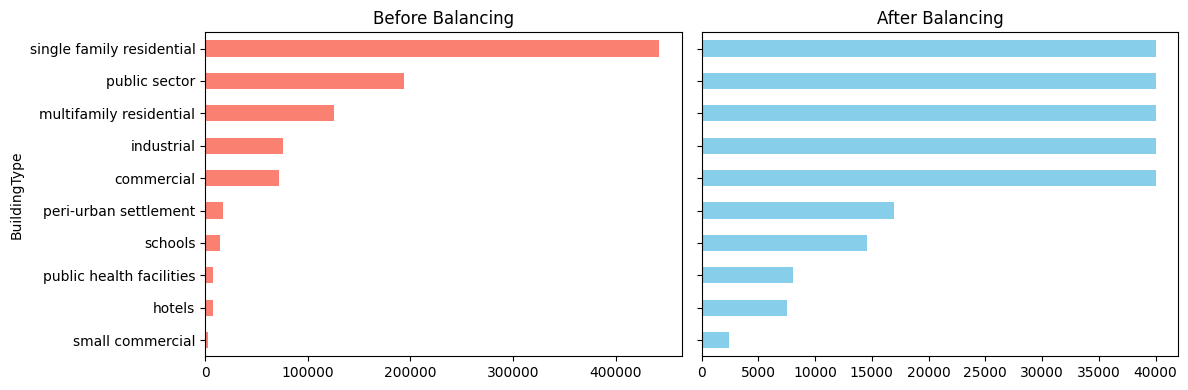

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)

df["BuildingType"].value_counts().sort_values().plot(kind="barh", ax=ax[0], color="salmon", title="Before Balancing")
balanced_df["BuildingType"].value_counts().sort_values().plot(kind="barh", ax=ax[1], color="skyblue", title="After Balancing")

plt.tight_layout()
plt.show()


In [4]:
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor, early_stopping
from xgboost import XGBRegressor

TARGET = "kWh_per_m2"
CAT = ["BuildingType"]
NUM = [
    "tilt","tilt2","tilt_sin","tilt_cos",
    "GHI_kWh_per_m2_day","AvgTemp_C",
    "ClearnessIndex","Precip_mm_per_day"
]

X = balanced_df[NUM + CAT].copy()
y = balanced_df[TARGET].copy()

for c in CAT:
    X[c] = X[c].astype("category")

y_log = np.log1p(y)
X_xgb = X.copy()
X_xgb["BuildingType"] = X_xgb["BuildingType"].cat.codes


In [5]:
xgb_params = dict(
    objective='reg:squarederror',
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_params = dict(
    objective='mae',
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=15,
    min_child_samples=100,
    lambda_l1=1.0,
    lambda_l2=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [ ]:
cv = GroupKFold(n_splits=3)
mae_scores = []

for fold, (tr, va) in enumerate(cv.split(X, y_log, groups=balanced_df["City"]), 1):
    X_tr_lgb, X_va_lgb = X.iloc[tr], X.iloc[va]
    X_tr_xgb, X_va_xgb = X_xgb.iloc[tr], X_xgb.iloc[va]
    y_tr, y_va = y_log.iloc[tr], y_log.iloc[va]

    # Train
    lgb = LGBMRegressor(**lgb_params)
    xgb = XGBRegressor(**xgb_params)
    xgb.fit(X_tr_xgb, y_tr, eval_set=[(X_va_xgb, y_va)], verbose=False)
    lgb.fit(X_tr_lgb, y_tr, eval_set=[(X_va_lgb, y_va)],
            callbacks=[early_stopping(stopping_rounds=150, verbose=False)])

    # Predict + blend
    pred_xgb = np.expm1(xgb.predict(X_va_xgb))
    pred_lgb = np.expm1(lgb.predict(X_va_lgb))
    meta = Ridge(alpha=1.0)
    meta.fit(np.column_stack([pred_xgb, pred_lgb]), np.expm1(y_va))
    stacked = meta.predict(np.column_stack([pred_xgb, pred_lgb]))

    mae = mean_absolute_error(np.expm1(y_va), stacked)
    mae_scores.append(mae)
    print(f"Fold {fold} MAE = {mae:.3f}")

print(f"\n🎯 Mean Stacked Ensemble MAE (balanced dataset): {np.mean(mae_scores):.3f} ± {np.std(mae_scores):.3f}")


[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 168309, number of used features: 9
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Start tr

In [ ]:
print("Previous model (unbalanced) MAE ≈ 16.6 ± 1.7")
print("New balanced-by-type model MAE → compare above")

Previous model (unbalanced) MAE ≈ 16.6 ± 1.7
New balanced-by-type model MAE → compare above


In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold
import numpy as np

TARGET = "kWh_per_m2"
CAT = ["BuildingType"]
NUM = [
    "tilt","tilt2","tilt_sin","tilt_cos",
    "GHI_kWh_per_m2_day","AvgTemp_C",
    "ClearnessIndex","Precip_mm_per_day"
]

X = balanced_df[NUM + CAT]
y = balanced_df[TARGET]

cv = GroupKFold(n_splits=3)
mae_scores = []

for fold, (tr, va) in enumerate(cv.split(X, y, groups=balanced_df["City"]), 1):
    model = CatBoostRegressor(
        iterations=1500,
        learning_rate=0.03,
        depth=8,
        l2_leaf_reg=3,
        loss_function='MAE',
        cat_features=CAT,
        random_state=42,
        verbose=0
    )
    model.fit(X.iloc[tr], y.iloc[tr])
    preds = model.predict(X.iloc[va])
    mae = mean_absolute_error(y.iloc[va], preds)
    mae_scores.append(mae)
    print(f"Fold {fold} MAE = {mae:.3f}")

print(f"\n🎯 Mean CatBoost MAE: {np.mean(mae_scores):.3f} ± {np.std(mae_scores):.3f}")


ModuleNotFoundError: No module named 'catboost'